# Document Description
``Overall: see the effect of the different parameters on User level
1.
2.
```

In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import ast
pd.options.plotting.backend = "plotly"
import plotly.express as px
# from chart_studio import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp
pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 70)

In [2]:
data = pd.read_csv('sorted_coded_data.csv')

# User 0

In [8]:
user_0=data[data.user_id==0]
user_0["start_time_hours"]=user_0.start_time/60/60

<ipython-input-8-d5f739a09399>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Initial statistics

In [4]:
print("number of observations:",user_0.shape[0])
print("number of distinct app:",user_0.app_code.nunique())
print("time period:",user_0.end_time.max()/60/60/24,"days")
print("most used apps:")
user_0.groupby('package_name').size().nlargest(10)

number of observations: 11339
number of distinct app: 66
time period: 233.9002546296296 days
most used apps:


package_name
com.facebook.katana                  2593
com.android.chrome                   1375
com.viber.voip                       1127
com.instagram.android                1044
com.sonyericsson.album                649
com.facebook.orca                     561
bg.abv.andro.emailapp                 513
com.google.android.apps.translate     500
com.google.android.youtube            426
com.whatsapp                          331
dtype: int64

We now limit the time period to make it easier to observe the data.

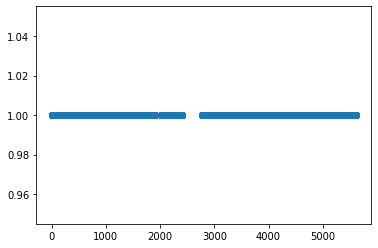

In [9]:
plt.scatter(user_0.start_time_hours,np.ones(user_0.shape[0]))
plt.show()

we select the first 24 hours

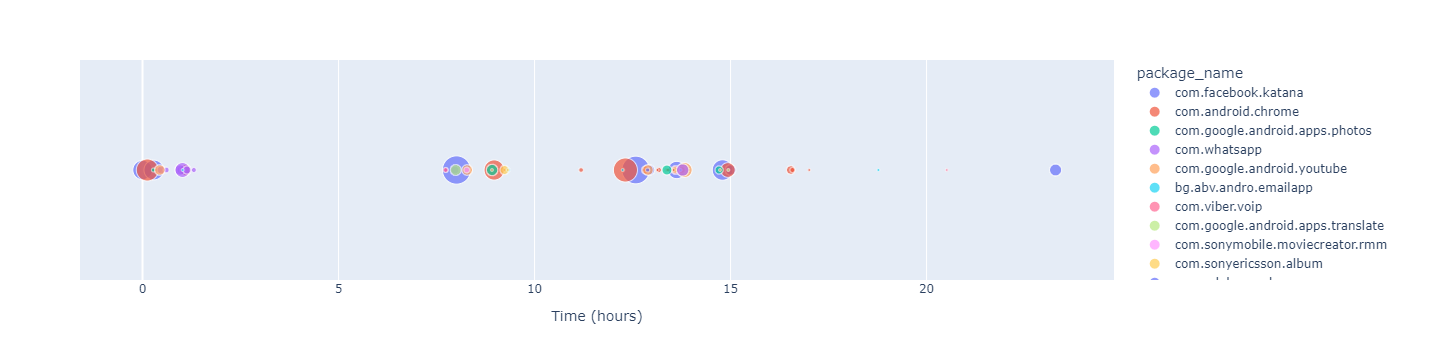

In [10]:
fig = px.scatter(user_0[user_0.start_time<=24*60*60], x="start_time_hours", y=np.ones(user_0[user_0.start_time<=24*60*60].shape[0]), color="package_name",
                 size='time_spend')
fig.update_layout(
    xaxis_title="Time (hours)",
    yaxis_title="")
fig.update_yaxes(visible=False)

fig.show()

## Sleep time distribution

We start by calculating the sleep time.

In [11]:
def join_times(x):
    startdf = pd.DataFrame({'time':x['start_time'], 'what':1})
    enddf = pd.DataFrame({'time':x['end_time'], 'what':-1})
    mergdf = pd.concat([startdf, enddf]).sort_values(['time','what'])
    mergdf['running'] = mergdf['what'].cumsum()
    mergdf['new_sequence'] = mergdf['running'].eq(1) & mergdf['what'].eq(1)
    mergdf['sequence_number'] = mergdf['new_sequence'].cumsum()
    x['sequence_number'] = mergdf['sequence_number'].loc[mergdf['what'].eq(1)]
    return x['sequence_number']

In [12]:
data['sequence_number']=data.groupby('user_id').apply(join_times).reset_index().drop(['user_id','level_1'], axis=1).values
data=pd.merge(data,data.groupby(['user_id','sequence_number']).agg({'start_time':'min','end_time':'max'}).reset_index().rename(columns={'end_time':'sequence_end_time','start_time':'sequence_Start_time'}),how='left', on=['user_id','sequence_number'])
data['sleep_time']=data.start_time-data.sequence_end_time.shift(1,fill_value=0) 

In [13]:
data.loc[data[data['sleep_time']<0].index,'sleep_time']=0

In [14]:
data.to_csv("sorted_coded_sleep_time.csv",index=False)

In [15]:
data= pd.read_csv("sorted_coded_sleep_time.csv")

In [22]:
user_0=data[data.user_id==0]
user_0['start_time_hours']=user_0.start_time/60/60

<ipython-input-22-c68b936e78d0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



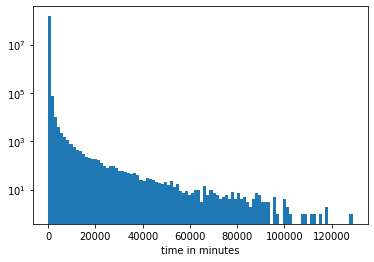

In [24]:
plt.hist(data[data.sleep_time>0].sleep_time/60,bins=100)
plt.xlabel('time in minutes')
plt.yscale('log')

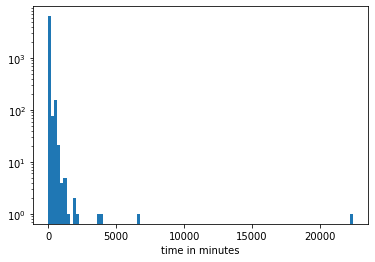

In [25]:
plt.hist(user_0[user_0.sleep_time>0].sleep_time/60,bins=100)
plt.xlabel('time in minutes')
plt.yscale('log')

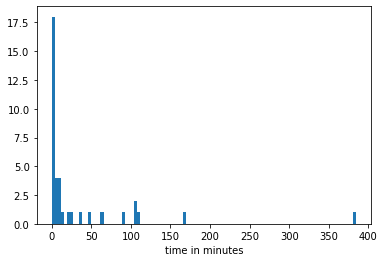

In [27]:
plt.hist(user_0[user_0.start_time_hours<=24][user_0[user_0.start_time_hours<=24].sleep_time>0].sleep_time/60,bins=100)
plt.xlabel('time in minutes')
plt.show()

In [28]:
print("median sleep time for full data set:",data[data.sleep_time>0].sleep_time.median())
print("median sleep time for full data set:",data[(data.sleep_time>0)&(data.sleep_time<8*60*60)].sleep_time.median())
print("median sleep time for full data set:",data[(data.sleep_time<8*60*60)].sleep_time.median())

median sleep time for full data set: 306.0
median sleep time for full data set: 293.0
median sleep time for full data set: 20.0


In [29]:
print("median sleep time for user 0:",user_0[user_0.sleep_time>0].sleep_time.median())
print("median sleep time less than 8 hours for user 0:",user_0[(user_0.sleep_time>0)&(user_0.sleep_time<8*60*60)].sleep_time.median())
print("median sleep time inclunding 0 but less than 8 hours for user 0:",user_0[(user_0.sleep_time<8*60*60)].sleep_time.median())

median sleep time for user 0: 367.0
median sleep time less than 8 hours for user 0: 336.0
median sleep time inclunding 0 but less than 8 hours for user 0: 10.0


### Calculating sessions based on the different thresholds

In [30]:
user_0['new_session'] = user_0.sleep_time.apply(lambda s: s>293.0)
user_0['session_293'] = user_0.new_session.cumsum().astype('int')

<ipython-input-30-27c4ba8147a3>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-27c4ba8147a3>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
user_0['new_session'] = user_0.sleep_time.apply(lambda s: s>20)
user_0['session_20'] = user_0.new_session.cumsum().astype('int')

<ipython-input-31-ad6a97ab519b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-ad6a97ab519b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
user_0["session_20"]=user_0["session_20"].astype(str)
user_0["session_293"]=user_0["session_293"].astype(str)

<ipython-input-32-0ab341e201f4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-0ab341e201f4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
fig = px.scatter(user_0[user_0.start_time_hours<=12], x="start_time_hours", y=np.ones(user_0[user_0.start_time_hours<=12].shape[0]),color=
                'session_20',height=200)
fig.update_layout(
    xaxis_title="Time (hours)",
    yaxis_title="",
showlegend=False)
fig.update_layout(xaxis_range=[-0.1,12])
fig.update_yaxes(visible=False)
fig.show()

In [38]:
fig = px.scatter(user_0[user_0.start_time_hours<=12], x="start_time_hours", y=np.ones(user_0[user_0.start_time_hours<=12].shape[0]),color=
                'session_293',height=200)
fig.update_layout(
    xaxis_title="Time (hours)",
    yaxis_title=""
,showlegend=False)
fig.update_layout(xaxis_range=[-0.1,12])
fig.update_yaxes(visible=False)
fig.show()

In [41]:
session_lengths_20s=user_0.groupby('session_20').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()

In [42]:
fig = px.bar(x=session_lengths_20s.index.values, y = session_lengths_20s.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

The plot above showing that there are 2862 sessions of length 1 when 20 seconds sleep threshold is used.

In [43]:
session_lengths_293=user_0.groupby('session_293').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()

In [44]:
fig = px.bar(x=session_lengths_293.index.values, y = session_lengths_293.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

### Combine repating apps within sessions.

In [45]:
user_0_20s=user_0.copy()

In [46]:
user_0_20s["previous_app_code"]=user_0_20s.groupby(["session_20"]).app_code.shift(1)

In [47]:
user_0_20s=user_0_20s[(user_0_20s.previous_app_code==user_0_20s.app_code) | (user_0_20s.app_code==user_0_20s.groupby(['session_20']).app_code.shift(-1))]

In [48]:
user_0_20s['new_event'] = user_0_20s.previous_app_code!=user_0_20s.app_code

In [49]:
user_0_20s['event'] = user_0_20s.groupby(['session_20']).new_event.cumsum().astype('int')

In [50]:
data2_grouped = user_0_20s.groupby(['session_20','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(user_0_20s, data2_grouped, how='left', on=['session_20','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['session_20','event'], keep='last')

In [51]:
max_index=user_0_20s.iloc[data3.index].index

In [52]:
data2_grouped = user_0_20s.groupby(['session_20','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(user_0_20s, data2_grouped, how='left', on=['session_20','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be opened at once.
data3=data3.drop_duplicates(subset=['session_20','event'], keep='last')

In [53]:
min_index=user_0_20s.iloc[data3.index].index

In [54]:
user_0_20s_final=user_0.copy()
user_0_20s_final["previous_app_code"]=user_0_20s_final.groupby(["session_20"]).app_code.shift(1)

In [55]:
user_0_20s_final.loc[max_index,"start_time"]=user_0_20s_final.loc[min_index].set_index(max_index).start_time

In [56]:
user_0_20s_final=user_0_20s_final.drop(set(user_0_20s.index)-set(max_index))

In [57]:
len(user_0.index)-(len(user_0_20s.index)-len(min_index))==len(user_0_20s_final.index)

True

In [58]:
user_0_20s_final['time_spend']=user_0_20s_final['end_time']-user_0_20s_final['start_time']

In [59]:
user_0_20s_final=user_0_20s_final.drop('previous_app_code',axis=1)

In [60]:
#Havent been run yet.
user_0_20s_final['sleep_time']=user_0_20s_final.start_time-data3.sequence_end_time.shift(1,fill_value=0)
user_0_20s_final.loc[user_0_20s_final[user_0_20s_final['sleep_time']<0].index,'sleep_time']=0

The process is now repeated but based on the 293 sec. sleep threshold.

In [61]:
user_0_293s=user_0.copy()
user_0_293s["previous_app_code"]=user_0_293s.groupby(["session_293"]).app_code.shift(1)
#Get relevant rows
user_0_293s=user_0_293s[(user_0_293s.previous_app_code==user_0_293s.app_code) | (user_0_293s.app_code==user_0_293s.groupby(['session_293']).app_code.shift(-1))]

user_0_293s['new_event'] = user_0_293s.previous_app_code!=user_0_293s.app_code
user_0_293s['event'] = user_0_293s.groupby(['session_293']).new_event.cumsum().astype('int')

In [62]:
data2_grouped = user_0_293s.groupby(['session_293','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(user_0_293s, data2_grouped, how='left', on=['session_293','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['session_293','event'], keep='last')

max_index=user_0_293s.iloc[data3.index].index

In [63]:
data2_grouped = user_0_293s.groupby(['session_293','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(user_0_293s, data2_grouped, how='left', on=['session_293','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be opened at once.
data3=data3.drop_duplicates(subset=['session_293','event'], keep='last')

min_index=user_0_293s.iloc[data3.index].index

In [64]:
user_0_293s_final=user_0.copy()
user_0_293s_final["previous_app_code"]=user_0_293s_final.groupby(["session_293"]).app_code.shift(1)

In [65]:
user_0_293s_final.loc[max_index,"start_time"]=user_0_293s_final.loc[min_index].set_index(max_index).start_time

In [66]:
user_0_293s_final=user_0_293s_final.drop(set(user_0_293s.index)-set(max_index))

In [67]:
len(user_0.index)-(len(user_0_293s.index)-len(max_index))==len(user_0_293s_final.index)

True

In [68]:
user_0_293s_final['time_spend']=user_0_293s_final['end_time']-user_0_293s_final['start_time']

In [69]:
user_0_293s_final=user_0_293s_final.drop('previous_app_code',axis=1)

In [70]:
#Havent been run yet.
user_0_293s_final['sleep_time']=user_0_293s_final.start_time-user_0_293s_final.sequence_end_time.shift(1,fill_value=0)
user_0_293s_final.loc[user_0_293s_final[user_0_293s_final['sleep_time']<0].index,'sleep_time']=0

After having merged the repeatin events, we look at the updated distributions of session length

In [71]:
updated_session_lengths_20=user_0_20s_final.groupby('session_20').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()
fig = px.bar(x=updated_session_lengths_20.index.values, y = updated_session_lengths_20.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

In [72]:
updated_session_lengths_293=user_0_293s_final.groupby('session_293').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()
fig = px.bar(x=updated_session_lengths_293.index.values, y = updated_session_lengths_293.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

After the merge of repeating events it is observed that the session lengths are shorter.

## Infrequent apps

We start by calculating the infrequency based on the app the user.

In [73]:
app_count_user_0_293=user_0_293s_final.groupby('package_name').size()

In [74]:
app_count_user_0_293.nlargest(10)

package_name
com.facebook.katana                  2363
com.android.chrome                   1212
com.instagram.android                 989
com.viber.voip                        983
com.sonyericsson.album                575
com.facebook.orca                     522
bg.abv.andro.emailapp                 510
com.google.android.apps.translate     415
com.google.android.youtube            380
com.whatsapp                          306
dtype: int64

In [75]:
app_count_user_0_293.nsmallest(10)

package_name
com.alibaba.aliexpresshd                 1
com.dreamob.android.enphv                1
com.fotoable.faceswap.c403               1
falcofinder.android.fce                  1
flv.mobile.android                       1
net.zedge.android                        1
subu.cambridgedictionary                 1
com.acobot.en                            2
com.chaisanamobile.kitchendesignideas    3
com.dekovir.pixwords                     3
dtype: int64

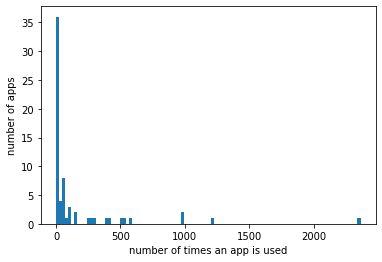

In [76]:
plt.hist(app_count_user_0_293,bins=100)
#plt.yscale('log')
plt.xlabel("number of times an app is used")
plt.ylabel("number of apps")
plt.show()

In [77]:
app_count_user_0_20=user_0_20s_final.groupby('package_name').size()

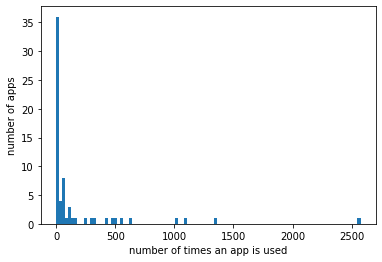

In [78]:
plt.hist(app_count_user_0_20,bins=100)
#plt.yscale('log')
plt.xlabel("number of times an app is used")
plt.ylabel("number of apps")
plt.show()

We can conclude that for user one, have a few apps that are used very frequent, bot most apps are not used that often.

In [79]:
app_count_all=data.groupby('package_name').size()

## Applying the infrequency threshold(0.01) for individual 

Initially the previous tunned threshold based on the individual users are used. This was 0.01%

In [80]:
infrequent_apps_user_0_20s=app_count_user_0_20[app_count_user_0_20/app_count_user_0_20.sum()*100<0.01]
infrequent_apps_user_0_293s=app_count_user_0_293[app_count_user_0_293/app_count_user_0_293.sum()*100<0.01]
infrequent_apps_all=app_count_all[app_count_all/app_count_all.sum()*100<0.01].index

In [81]:
print("User infrequent apps for 20s sleep threshold:")
print("Number of infrequent apps:",infrequent_apps_user_0_20s.shape[0])
print("Number of frequent apps:",user_0.app_code.nunique()-infrequent_apps_user_0_20s.shape[0])
print()
print("User infrequent apps for 293s sleep threshold:")
print("Number of infrequent apps:",infrequent_apps_user_0_293s.shape[0])
print("Number of frequent apps:",user_0.app_code.nunique()-infrequent_apps_user_0_293s.shape[0])

User infrequent apps for 20s sleep threshold:
Number of infrequent apps: 6
Number of frequent apps: 60

User infrequent apps for 293s sleep threshold:
Number of infrequent apps: 7
Number of frequent apps: 59


For comparisons sake we now take a look at which apps would have been infrequent if the 0.01 threshold was based on the observations across the users.

In [82]:
user_0_20s_final["infrequen_overall_0_01"]=user_0_20s_final.package_name.apply(lambda l: l in infrequent_apps_all)

In [83]:
user_0_293s_final["infrequen_overall_0_01"]=user_0_293s_final.package_name.apply(lambda l: l in infrequent_apps_all)

In [84]:
print("User infrequent apps for 20s sleep threshold:")
print("Number of infrequent apps:",user_0_20s_final[user_0_20s_final.infrequen_overall_0_01].app_code.nunique())
print("Number of frequent apps:",user_0.app_code.nunique()-user_0_20s_final[user_0_20s_final.infrequen_overall_0_01].app_code.nunique())
print()
print("User infrequent apps for 293s sleep threshold:")
print("Number of infrequent apps:",user_0_293s_final[user_0_293s_final.infrequen_overall_0_01].app_code.nunique())
print("Number of frequent apps:",user_0.app_code.nunique()-user_0_293s_final[user_0_293s_final.infrequen_overall_0_01].app_code.nunique())


User infrequent apps for 20s sleep threshold:
Number of infrequent apps: 25
Number of frequent apps: 41

User infrequent apps for 293s sleep threshold:
Number of infrequent apps: 25
Number of frequent apps: 41


We see that there is actual a different and when the overall infrequent apps is being applied, two apps are being labeled as infrequent, which are actually not infrequent for user 0.

#### What´s apps been recognized as infrequent
-include comparision to what is labeled as infrequent for 0.01 threshold for whole data set.

We now take a look at which specific apps where removed from.

In [85]:
infrequent_apps_user_0_20s.index

Index(['com.alibaba.aliexpresshd', 'com.dreamob.android.enphv',
       'com.fotoable.faceswap.c403', 'falcofinder.android.fce',
       'flv.mobile.android', 'subu.cambridgedictionary'],
      dtype='object', name='package_name')

In [86]:
user_0_20s_final["infrequent_0_01"]=user_0_20s_final.package_name.apply(lambda l: l in infrequent_apps_user_0_20s.index)
user_0_293s_final["infrequent_0_01"]=user_0_293s_final.package_name.apply(lambda l: l in infrequent_apps_user_0_293s.index)

In [87]:
print("frequent apps for user 0, that are infrequent for overall")
set(user_0_20s_final[user_0_20s_final.infrequen_overall_0_01].package_name.unique())-set(infrequent_apps_user_0_20s.index)

frequent apps for user 0, that are infrequent for overall


{'air.ca.udesignit.kitchen',
 'bg.abv.andro.emailapp',
 'com.acobot.en',
 'com.campursari.photoeditan',
 'com.chaisanamobile.kitchendesignideas',
 'com.dekovir.pixwords',
 'com.fotoable.fotobeauty',
 'com.fotoable.photocollage',
 'com.funbox.englishidioms',
 'com.google.android.apps.youtube.kids',
 'com.google.earth',
 'com.instagram.layout',
 'com.intsig.camscanner',
 'com.jb.zcamera',
 'com.memrise.android.memrisecompanion',
 'com.msvdevelopment.enbulgar.free',
 'com.sirmamobile.prodavalnik',
 'com.tayu.tau.pedometer',
 'com.videoultrak.ddvideo',
 'net.zedge.android'}

In [88]:
print("infrequent apps for user 0, that are frequent for overall")
set(infrequent_apps_user_0_20s.index)-set(user_0_20s_final[user_0_20s_final.infrequen_overall_0_01].package_name.unique())

infrequent apps for user 0, that are frequent for overall


{'com.alibaba.aliexpresshd'}

We now take a look at how frequent the apps that are frequent for user 0 but not overall frequent are.

In [89]:
(app_count_user_0_20/app_count_user_0_20.sum()*100)[app_count_user_0_20.index.to_series().apply(lambda l: l in (set(user_0_20s_final[user_0_20s_final.infrequen_overall_0_01].package_name.unique())-set(infrequent_apps_user_0_20s.index)))].sort_values()

package_name
net.zedge.android                        0.017821
com.acobot.en                            0.017821
com.chaisanamobile.kitchendesignideas    0.026731
com.dekovir.pixwords                     0.026731
com.funbox.englishidioms                 0.026731
com.memrise.android.memrisecompanion     0.035641
com.google.earth                         0.035641
air.ca.udesignit.kitchen                 0.035641
com.videoultrak.ddvideo                  0.053462
com.intsig.camscanner                    0.053462
com.fotoable.fotobeauty                  0.062372
com.fotoable.photocollage                0.071282
com.campursari.photoeditan               0.106923
com.tayu.tau.pedometer                   0.142564
com.instagram.layout                     0.302949
com.jb.zcamera                           0.392052
com.sirmamobile.prodavalnik              0.481155
com.msvdevelopment.enbulgar.free         0.498975
com.google.android.apps.youtube.kids     0.695001
bg.abv.andro.emailapp                

many of the apps removed by using the overall threshold for labiling apps as infrequent, are very frequent. For instants bg.abv.andro.emailapp which was also part of user 0's top 10 most used apps.

We now take a look at the difference for user 0 where the sessions were defined with the 239sec threshold.

In [90]:
infrequent_apps_user_0_293s.index

Index(['com.alibaba.aliexpresshd', 'com.dreamob.android.enphv',
       'com.fotoable.faceswap.c403', 'falcofinder.android.fce',
       'flv.mobile.android', 'net.zedge.android', 'subu.cambridgedictionary'],
      dtype='object', name='package_name')

In [91]:
print("frequent apps for user 0 (293 sec. sessions), that are infrequent for overall")
set(user_0_293s_final[user_0_293s_final.infrequen_overall_0_01].package_name.unique())-set(infrequent_apps_user_0_293s.index)

frequent apps for user 0 (293 sec. sessions), that are infrequent for overall


{'air.ca.udesignit.kitchen',
 'bg.abv.andro.emailapp',
 'com.acobot.en',
 'com.campursari.photoeditan',
 'com.chaisanamobile.kitchendesignideas',
 'com.dekovir.pixwords',
 'com.fotoable.fotobeauty',
 'com.fotoable.photocollage',
 'com.funbox.englishidioms',
 'com.google.android.apps.youtube.kids',
 'com.google.earth',
 'com.instagram.layout',
 'com.intsig.camscanner',
 'com.jb.zcamera',
 'com.memrise.android.memrisecompanion',
 'com.msvdevelopment.enbulgar.free',
 'com.sirmamobile.prodavalnik',
 'com.tayu.tau.pedometer',
 'com.videoultrak.ddvideo'}

In [92]:
print("infrequent apps for user 0 (293 sec. session), that are frequent for overall")
set(infrequent_apps_user_0_293s.index)-set(user_0_293s_final[user_0_293s_final.infrequen_overall_0_01].package_name.unique())

infrequent apps for user 0 (293 sec. session), that are frequent for overall


{'com.alibaba.aliexpresshd'}

We now take a look at how frequent the apps that are frequent for user 0 but not overall frequent are.

In [93]:
(app_count_user_0_293/app_count_user_0_293.sum()*100)[app_count_user_0_293.index.to_series().apply(lambda l: l in (set(user_0_293s_final[user_0_293s_final.infrequen_overall_0_01].package_name.unique())-set(infrequent_apps_user_0_293s.index)))].sort_values()

package_name
com.acobot.en                            0.019301
com.chaisanamobile.kitchendesignideas    0.028952
com.dekovir.pixwords                     0.028952
com.funbox.englishidioms                 0.028952
air.ca.udesignit.kitchen                 0.038603
com.memrise.android.memrisecompanion     0.038603
com.google.earth                         0.038603
com.videoultrak.ddvideo                  0.048253
com.fotoable.fotobeauty                  0.057904
com.intsig.camscanner                    0.057904
com.fotoable.photocollage                0.077205
com.campursari.photoeditan               0.115808
com.tayu.tau.pedometer                   0.135109
com.instagram.layout                     0.308821
com.jb.zcamera                           0.424628
com.msvdevelopment.enbulgar.free         0.501834
com.sirmamobile.prodavalnik              0.511484
com.google.android.apps.youtube.kids     0.646593
bg.abv.andro.emailapp                    4.921830
dtype: float64

###  Sessions after infrequecy app are removed.

In [94]:
user_0_20s_final.to_csv("user_0_20s_merged.csv",index=False)
user_0_293s_final.to_csv("user_0_293s_merged.csv",index=False)

In [95]:
user_0_20s_without_infrequent=user_0_20s_final[user_0_20s_final.infrequent_0_01.apply(lambda l: not l)]
user_0_20s_without_overall_infrequent=user_0_20s_final[user_0_20s_final.infrequen_overall_0_01.apply(lambda l: not l)]
user_0_293s_without_infrequent=user_0_293s_final[user_0_293s_final.infrequent_0_01.apply(lambda l: not l)]
user_0_293s_without_overall_infrequent=user_0_293s_final[user_0_293s_final.infrequen_overall_0_01.apply(lambda l: not l)]

We now take a look at how the sessions look after the infrequnent apps have been removed.

In [96]:
user_0_20s_without_infrequent.loc[:,'start_time']=user_0_20s_without_infrequent.loc[:,'start_time']/60/60

/home/s164574/.conda/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### sessions with a 20 seconds sleep time threshold without individually defined 0.01-infrequent apps

In [102]:
fig = px.scatter(user_0_20s_without_infrequent[user_0_20s_without_infrequent.start_time_hours<=12], x="start_time_hours", y=np.ones(user_0_20s_without_infrequent[user_0_20s_without_infrequent.start_time_hours<=12].shape[0]),color=
                'session_20',height=200)
fig.update_layout(
    xaxis_title="Time (hours)",
    yaxis_title="",showlegend=False)
fig.update_layout(xaxis_range=[-0.1,12])
fig.update_yaxes(visible=False)
fig.show()

#### sessions with a 20 seconds sleep time threshold without overall defined 0.01-infrequent apps

In [103]:
fig = px.scatter(user_0_20s_without_overall_infrequent[user_0_20s_without_overall_infrequent.start_time_hours<=12], x="start_time_hours", y=np.ones(user_0_20s_without_overall_infrequent[user_0_20s_without_overall_infrequent.start_time_hours<=12].shape[0]),color=
                'session_20',height=200)
fig.update_layout(
    xaxis_title="Time (hours)",
    yaxis_title="",showlegend=False)
fig.update_layout(xaxis_range=[-0.1,12])
fig.update_yaxes(visible=False)
fig.show()

#### sessions with a 293 seconds sleep time threshold without individually defined 0.01-infrequent apps

In [100]:
fig = px.scatter(user_0_293s_without_infrequent[user_0_293s_without_infrequent.start_time_hours<=12], x="start_time_hours", y=np.ones(user_0_293s_without_infrequent[user_0_293s_without_infrequent.start_time_hours<=12].shape[0]),color=
                'session_293',height=200)
fig.update_layout(
    xaxis_title="Time (hours)",
    yaxis_title="",showlegend=False)
fig.update_layout(xaxis_range=[-0.1,12])
fig.update_yaxes(visible=False)
fig.show()

#### sessions with a 293 seconds sleep time threshold without overall defined 0.01-infrequent apps

In [104]:
fig = px.scatter(user_0_293s_without_overall_infrequent[user_0_293s_without_overall_infrequent.start_time_hours<=12], x="start_time_hours", y=np.ones(user_0_293s_without_overall_infrequent[user_0_293s_without_overall_infrequent.start_time_hours<=12].shape[0]),color=
                'session_293',height=200)
fig.update_layout(
    xaxis_title="Time (hours)",
    yaxis_title="",showlegend=False)
fig.update_layout(xaxis_range=[-0.1,12])
fig.update_yaxes(visible=False)
fig.show()

In [109]:
print("Number of observations starting in the first 12 hours, after infrequent apps overall are removed:", user_0_293s_without_overall_infrequent[user_0_293s_without_overall_infrequent.start_time_hours<=12].shape[0])
print("Number of observations starting in the first 12 hours, after infrequent apps individual are removed:",user_0_293s_without_infrequent[user_0_293s_without_infrequent.start_time_hours<=12].shape[0])

Number of observations starting in the first 12 hours, after infrequent apps overall are removed: 28
Number of observations starting in the first 12 hours, after infrequent apps individual are removed: 30


In [110]:
print("Number of observations starting in the first 12 hours, after infrequent apps overall are removed:",user_0_20s_without_overall_infrequent[user_0_20s_without_overall_infrequent.start_time_hours<=12].shape[0])
print("Number of observations starting in the first 12 hours, after infrequent apps individual are removed:",user_0_20s_without_infrequent[user_0_20s_without_infrequent.start_time_hours<=12].shape[0])

Number of observations starting in the first 12 hours, after infrequent apps overall are removed: 29
Number of observations starting in the first 12 hours, after infrequent apps individual are removed: 31


The differences are hard to observed as not so manny apps within the 12 hours period is removed. We now look at the overall distribution of lengths of sequenses.

#### distibution of session (20sec) length with individual infrequent apps removed.

In [111]:
updated_session_lengths_20s_without_infrequent=user_0_20s_without_infrequent.groupby('session_20').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()
fig = px.bar(x=updated_session_lengths_20s_without_infrequent.index.values, y = updated_session_lengths_20s_without_infrequent.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

#### distibution of session (20sec) length with overall infrequent apps removed.

In [112]:
updated_session_lengths_20s_without_overall_infrequent=user_0_20s_without_overall_infrequent.groupby('session_20').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()
fig = px.bar(x=updated_session_lengths_20s_without_overall_infrequent.index.values, y = updated_session_lengths_20s_without_overall_infrequent.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

#### distibution of session (293sec) length with individual infrequent apps removed.

In [113]:
updated_session_lengths_293s_without_infrequent=user_0_293s_without_infrequent.groupby('session_293').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()
fig = px.bar(x=updated_session_lengths_293s_without_infrequent.index.values, y = updated_session_lengths_293s_without_infrequent.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

#### distibution of session (293sec) length with overall infrequent apps removed.

In [115]:
updated_session_lengths_293s_without_overall_infrequent=user_0_293s_without_overall_infrequent.groupby('session_293').agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).groupby('session_length').size()
fig = px.bar(x=updated_session_lengths_293s_without_overall_infrequent.index.values, y = updated_session_lengths_293s_without_overall_infrequent.values,width=625,height=400)
fig.update_layout(
    xaxis_title="Number of apps in session",
    yaxis_title="Number of sessions")
fig.update_xaxes(type='category')

Over all we see that with the overall infrequency the sessions becomes shorter, compared to when the infrequent apps are calculated one the individual user.

### What frequent patterns are returned (with constant min sup.)
Here we will take a look at if the frequent patterns found for user 0 are different, for the different session and frequency definitions. For comparisons sake an constant min. sup. of one is used.

In [118]:
input_string=user_0_20s_without_overall_infrequent.groupby(['session_20'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_20s__overall_infrequent.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_20sec_sessions_overall_infrequent.txt'), 'w')
f.write(dfAsString)
f.close()

In [119]:
input_string=user_0_20s_without_infrequent.groupby(['session_20'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_20s_individual_infrequent.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_20sec_sessions_individual_infrequent.txt'), 'w')
f.write(dfAsString)
f.close()

In [120]:
input_string=user_0_293s_without_overall_infrequent.groupby(['session_293'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_293s__overall_infrequent.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_293sec_sessions_overall_infrequent.txt'), 'w')
f.write(dfAsString)
f.close()

In [121]:
input_string=user_0_293s_without_infrequent.groupby(['session_293'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_293s_individual_infrequent.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_293sec_sessions_individual_infrequent.txt'), 'w')
f.write(dfAsString)
f.close()

In [126]:
app_dict = pd.read_csv('sorted_coded_data.csv')
app_dict=dict(zip(app_dict.app_code, app_dict.package_name))

In [122]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_20sec_sessions_overall_infrequent.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_20sec_sessions_overall_infrequent_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 20 sec. and overall infrequency")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_20sec_sessions_overall_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 171 ms
 Frequent sequences count : 47
 Max memory (mb) : 82.0001754760742247
minsup 53
Intersection count 226 


maximal patterns with 1% sup. for user 0 with 20 sec. and overall infrequency
                  pattern  sup
0                 [45264]  152
1                 [44582]   53
2                 [34335]   58
3                 [24691]   76
4                 [23916]  122
5                 [23906]  101
6                 [18676]   71
7                  [7655]   55
8                  [7648]   58
9                  [6577]  162
10                 [2262]  103
11         [45260, 51657]   54
12         [45260, 45260]   60
13         [53003, 27441]   55
14         [51657, 27441]  126
15         [27441, 51657]   82
16         [19968, 53003]   63
17         [53003, 19968]   83
18         [45260, 27441]  104
19         [51657, 19973]   56
20         [45260, 19968]  108


In [127]:
output=pd.read_csv("output_VMSP_user_0_20sec_sessions_overall_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_20sec_sessions_overall_infrequent_min_sup_1_translated.csv",index=False)

In [129]:
output

,pattern,sup,pattern_length
9,[com.adobe.reader],162,1
0,[com.sonyericsson.conversations],152,1
14,"[com.viber.voip, com.instagram.android]",126,2
4,[com.google.android.apps.photos],122,1
33,"[com.facebook.katana, com.google.android.apps.translate]",113,2
20,"[com.sonyericsson.album, com.facebook.katana]",108,2
18,"[com.sonyericsson.album, com.instagram.android]",104,2
10,[bbc.mobile.weather],103,1
23,"[com.instagram.android, com.instagram.android]",102,2
5,[com.google.android.apps.maps],101,1


In [128]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 11
Max lengths of frequent patterns: 3


In [123]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_20sec_sessions_individual_infrequent.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_20sec_sessions_individual_infrequent_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 20 sec. and individual infrequency")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_20sec_sessions_individual_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 153 ms
 Frequent sequences count : 51
 Max memory (mb) : 82.0002288818359451
minsup 55
Intersection count 217 


maximal patterns with 1% sup. for user 0 with 20 sec. and individual infrequency
                  pattern  sup
0                 [45264]  152
1                 [35031]   55
2                 [34335]   58
3                 [24691]   76
4                 [23936]   74
5                 [23916]  122
6                 [23906]  101
7                 [18676]   71
8                  [7655]   55
9                  [7648]   58
10                 [6577]  162
11                 [2262]  103
12         [45260, 45260]   60
13         [53003, 27441]   55
14         [51657, 27441]  126
15         [27441, 51657]   82
16         [19968, 53003]   63
17         [53003, 19968]   83
18         [27441, 45260]  125
19         [45260, 27441]  104
20         [51657, 19973]   

In [130]:
output=pd.read_csv("output_VMSP_user_0_20sec_sessions_individual_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_20sec_sessions_individual_infrequent_min_sup_1_translated.csv",index=False)

In [131]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 12
Max lengths of frequent patterns: 3


In [124]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_293sec_sessions_overall_infrequent.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_293sec_sessions_overall_infrequent_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 293 sec. and overall infrequency")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_293sec_sessions_overall_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 160 ms
 Frequent sequences count : 131
 Max memory (mb) : 82.00012969970703131
minsup 35
Intersection count 968 


maximal patterns with 1% sup. for user 0 with 293 sec. and overall infrequency
                        pattern  sup
0                       [44582]   47
1                       [34335]   51
2                       [24691]   72
3                       [18676]   62
4                        [7655]   54
..                          ...  ...
126  [19968, 7649, 19968, 7649]   62
127  [7649, 19968, 7649, 19968]   45
128  [19968, 7649, 7649, 19968]   40
129   [7649, 19968, 7649, 7649]   35
130   [7649, 7649, 19968, 7649]   39

[131 rows x 2 columns]


In [132]:
output=pd.read_csv("output_VMSP_user_0_293sec_sessions_overall_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_293sec_sessions_overall_infrequent_min_sup_1_translated.csv",index=False)

In [133]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 6
Max lengths of frequent patterns: 4


In [125]:
# A test using there package 
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_293sec_sessions_individual_infrequent.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_293sec_sessions_individual_infrequent_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 293 sec. and individual infrequency")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_293sec_sessions_individual_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 166 ms
 Frequent sequences count : 143
 Max memory (mb) : 82.00012969970703143
minsup 36
Intersection count 1037 


maximal patterns with 1% sup. for user 0 with 293 sec. and individual infrequency
                        pattern  sup
0                       [44582]   47
1                       [44393]   50
2                       [35031]   51
3                       [34335]   51
4                       [28268]   43
..                          ...  ...
138  [19968, 7649, 27441, 7649]   36
139  [19968, 7649, 7649, 19968]   40
140  [7649, 19968, 7649, 19968]   45
141  [19968, 7649, 19968, 7649]   62
142   [7649, 7649, 19968, 7649]   39

[143 rows x 2 columns]


In [134]:
output=pd.read_csv("output_VMSP_user_0_293sec_sessions_individual_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_293sec_sessions_individual_infrequent_min_sup_1_translated.csv",index=False)

In [135]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 10
Max lengths of frequent patterns: 4


While the algorithms are here only run on data for user 0 we can see that the patterns that dependent on the sleep time threshold used there are big differences in the number and length of patterns we find. Furthermore when comparing between the two infrequency methods there can also be observed differences.


When running VMPS on the whole data set we have been removing any sessions with only one app. There for it is tested if how that will affect the results when only running on user 0.

In [137]:
user_0_20s_without_overall_infrequent=pd.merge(user_0_20s_without_overall_infrequent,(user_0_20s_without_overall_infrequent.groupby(['session_20']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length'}),how='left',on=['session_20'])

In [139]:
user_0_20s_without_infrequent=pd.merge(user_0_20s_without_infrequent,(user_0_20s_without_infrequent.groupby(['session_20']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length'}),how='left',on=['session_20'])
user_0_293s_without_overall_infrequent=pd.merge(user_0_293s_without_overall_infrequent,(user_0_293s_without_overall_infrequent.groupby(['session_293']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length'}),how='left',on=['session_293'])
user_0_293s_without_infrequent=pd.merge(user_0_293s_without_infrequent,(user_0_293s_without_infrequent.groupby(['session_293']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length'}),how='left',on=['session_293'])

In [140]:
input_string=user_0_20s_without_overall_infrequent[user_0_20s_without_overall_infrequent.session_length>1].groupby(['session_20'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_20s_overall_infrequent_min_length_2.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_20sec_sessions_overall_infrequent_min_length_2.txt'), 'w')
f.write(dfAsString)
f.close()

In [141]:
input_string=user_0_20s_without_infrequent[user_0_20s_without_infrequent.session_length>1].groupby(['session_20'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_20s_individual_infrequent_min_length_2.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_20sec_sessions_individual_infrequent_min_length_2.txt'), 'w')
f.write(dfAsString)
f.close()

In [142]:
input_string=user_0_293s_without_overall_infrequent[user_0_293s_without_overall_infrequent.session_length>1].groupby(['session_293'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_293s__overall_infrequent_min_length_2.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_293sec_sessions_overall_infrequent_min_length_2.txt'), 'w')
f.write(dfAsString)
f.close()

In [143]:
input_string=user_0_293s_without_infrequent[user_0_293s_without_infrequent.session_length>1].groupby(['session_293'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")
input_string.to_csv("input_string_user0_293s_individual_infrequent_min_length_2.csv",index=False)
dfAsString = input_string.to_string(header=False, index=False).lstrip()
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f = open(os.path.join(os.getcwd(), 'user_0_293sec_sessions_individual_infrequent_min_length_2.txt'), 'w')
f.write(dfAsString)
f.close()

In [144]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_20sec_sessions_overall_infrequent_min_length_2.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_20sec_sessions_overall_infrequent_min_length_2_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 20 sec. without length one sessions")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_20sec_sessions_min_length_2_overall_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 124 ms
 Frequent sequences count : 115
 Max memory (mb) : 71.75015258789062115
minsup 24
Intersection count 726 


maximal patterns with 1% sup. for user 0 with 20 sec. without length one sessions
                        pattern  sup
0                       [50264]   29
1                       [44582]   45
2                       [34335]   47
3                       [18676]   45
4                        [7655]   37
..                          ...  ...
110         [27441, 7649, 7649]   30
111         [7649, 7649, 27441]   27
112         [7649, 27441, 7649]   35
113         [7649, 7649, 19968]   36
114  [19968, 7649, 19968, 7649]   31

[115 rows x 2 columns]


In [145]:
output=pd.read_csv("output_VMSP_user_0_20sec_sessions_min_length_2_overall_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_20sec_sessions_min_length_2_overall_infrequent_min_sup_1_translated.csv",index=False)

In [146]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 6
Max lengths of frequent patterns: 4


In [147]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_20sec_sessions_individual_infrequent_min_length_2.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_20sec_sessions_individual_infrequent_min_length_2_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 20 sec. and individual infrequency without length one sessions")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_20sec_sessions_length_2_individual_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 136 ms
 Frequent sequences count : 112
 Max memory (mb) : 71.75012969970703112
minsup 27
Intersection count 678 


maximal patterns with 1% sup. for user 0 with 20 sec. and individual infrequency without length one sessions
                        pattern  sup
0                       [50264]   29
1                       [44582]   45
2                       [44393]   48
3                       [35031]   37
4                       [34335]   47
..                          ...  ...
107         [7649, 27441, 7649]   35
108         [7649, 7649, 27441]   27
109        [19968, 2340, 19968]   30
110         [7649, 7649, 19968]   36
111  [19968, 7649, 19968, 7649]   31

[112 rows x 2 columns]


In [148]:
output=pd.read_csv("output_VMSP_user_0_20sec_sessions_length_2_individual_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_20sec_sessions_length_2_individual_infrequent_min_sup_1_translated.csv",index=False)

In [149]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 12
Max lengths of frequent patterns: 4


In [150]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_293sec_sessions_overall_infrequent_min_length_2.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_293sec_sessions_overall_infrequent_min_length_2_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 293 sec. and overall infrequency without length one sessions")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_293sec_sessions_length_2_overall_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 170 ms
 Frequent sequences count : 268
 Max memory (mb) : 82.0001449584961268
minsup 21
Intersection count 2142 


maximal patterns with 1% sup. for user 0 with 293 sec. and overall infrequency without length one sessions
                                 pattern  sup
0                                [50264]   32
1                                [34335]   48
2                                 [7655]   43
3                                 [7648]   40
4                         [53003, 51657]   37
..                                   ...  ...
263            [19968, 7649, 7649, 7649]   30
264             [7649, 7649, 7649, 7649]   21
265  [19968, 27441, 19968, 27441, 19968]   21
266    [19968, 7649, 19968, 7649, 19968]   27
267     [7649, 19968, 7649, 19968, 7649]   22

[268 rows x 2 columns]


In [151]:
output=pd.read_csv("output_VMSP_user_0_293sec_sessions_length_2_overall_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_293sec_sessions_length_2_overall_infrequent_min_sup_1_translated.csv",index=False)

In [152]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 4
Max lengths of frequent patterns: 5


In [153]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/user_0_293sec_sessions_individual_infrequent_min_length_2.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_user_0_293sec_sessions_individual_infrequent_min_length_2_min_sup_1.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.01])
spmf.run()
print("maximal patterns with 1% sup. for user 0 with 293 sec. and individual infrequency without length one sessions")
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_user_0_293sec_sessions_length_2_individual_infrequent_min_sup_1.csv")

>/home/s164574/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 188 ms
 Frequent sequences count : 275
 Max memory (mb) : 82.0001449584961275
minsup 23
Intersection count 2204 


maximal patterns with 1% sup. for user 0 with 293 sec. and individual infrequency without length one sessions
                               pattern  sup
0                              [50264]   32
1                              [44393]   49
2                              [35031]   40
3                              [34335]   48
4                              [28268]   39
..                                 ...  ...
270         [7649, 19968, 19968, 7649]   29
271          [19968, 7649, 7649, 7649]   30
272          [7649, 7649, 19968, 7649]   39
273          [7649, 19968, 7649, 7649]   35
274  [19968, 7649, 19968, 7649, 19968]   27

[275 rows x 2 columns]


In [154]:
output=pd.read_csv("output_VMSP_user_0_293sec_sessions_length_2_individual_infrequent_min_sup_1.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_user_0_293sec_sessions_length_2_individual_infrequent_min_sup_1_translated.csv",index=False)

In [155]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 9
Max lengths of frequent patterns: 5
